<a href="https://colab.research.google.com/github/zakariaelaoufi/arcface-pytorch/blob/main/arcface_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install opendatasets --quiet

import opendatasets as od
import os

od.download('https://www.kaggle.com/datasets/hearfool/vggface2')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gyu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/hearfool/vggface2


100%|██████████| 2.32G/2.32G [00:16<00:00, 151MB/s]


In [7]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
path_train = '/content/vggface2/train'
path_val = '/content/vggface2/val'

In [9]:
def generate_vggface_df(dir):
  image_path = []
  image_label = []

  for i, folder in enumerate(os.listdir(dir)):
    for image in os.listdir(dir + "/" + folder):
      curr_path = dir + "/" + folder + "/" + image
      image_path.append(curr_path)
      image_label.append(i)

  return pd.DataFrame(zip(image_path, image_label), columns = ['image_path', 'label'])

In [10]:
train_df = generate_vggface_df(path_train)
val_df = generate_vggface_df(path_val)

In [11]:
train_df.to_csv("vggfave_train.csv")
val_df.to_csv("vggfave_val.csv")

In [12]:
from sklearn.model_selection import train_test_split

# Split the original val_df into new val_df and test_df with stratification
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df['label'], random_state=42)

In [13]:
train_df.sample(5)

,image_path,label
158867,/content/vggface2/train/n000047/0230_01.jpg,437
110316,/content/vggface2/train/n000076/0200_01.jpg,305
73564,/content/vggface2/train/n000215/0315_01.jpg,203
56735,/content/vggface2/train/n000438/0573_01.jpg,156
25934,/content/vggface2/train/n000154/0476_02.jpg,72


In [14]:
val_df.sample(5)

,image_path,label
13261,/content/vggface2/val/n001197/0129_01.jpg,38
13828,/content/vggface2/val/n000394/0005_02.jpg,40
19750,/content/vggface2/val/n001127/0099_01.jpg,55
2981,/content/vggface2/val/n000659/0117_02.jpg,8
15499,/content/vggface2/val/n001277/0045_01.jpg,44


In [15]:
len(train_df), len(val_df), len(test_df)

(176398, 10647, 10648)

<Axes: ylabel='Frequency'>

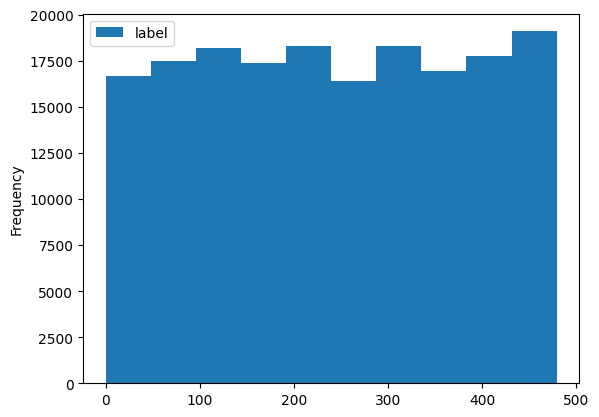

In [16]:
train_df.plot(kind='hist')

In [17]:
path_sample = train_df['image_path'].sample(1).iloc[0]

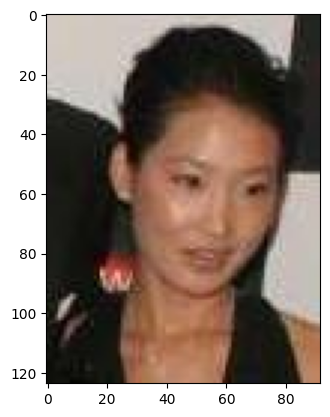

In [18]:
image = cv2.imread(path_sample)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()

In [19]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn import Sequential, CrossEntropyLoss, MSELoss, L1Loss
from torchvision.transforms import transforms
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
def resize_image(image, dsize=(224, 224)):
    resized_image = cv2.resize(image, dsize=dsize, interpolation=cv2.INTER_LANCZOS4)
    return resized_image

In [21]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

transform_augmented = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # transforms.RandomCrop(180, padding=10),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [22]:
class customDatasets(Dataset):
  def __init__(self, dataframe, transform=None):
     super().__init__()
     self.dataframe = dataframe
     self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path = self.dataframe.iloc[index, 0]
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = resize_image(image_rgb)
    label = torch.tensor(self.dataframe.iloc[index]['label'], dtype=torch.long)

    if self.transform:
      image_resized = self.transform(image_resized)

    return image_resized.to(device), label

In [23]:
train_dataset = customDatasets(train_df, transformer)
# augmented_train_dataset = customDatasets(train_df, transform=transform_augmented)
test_dataset = customDatasets(test_df, transform=transformer)
val_dataset = customDatasets(val_df, transform=transformer)

In [40]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

(224, 224, 3)


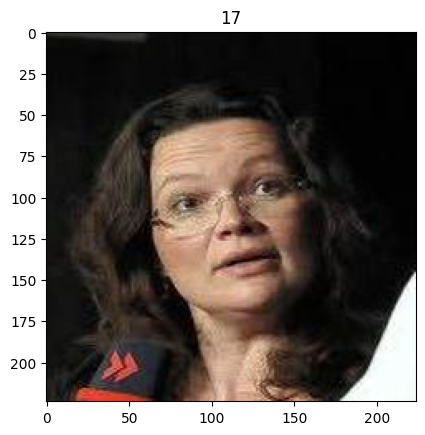

In [41]:
images, labels = next(iter(train_dataloader))
images = images.cpu().numpy()
labels = labels.cpu().numpy()

for i in range(len(images)):
    image = images[i].transpose(1, 2, 0)  # Convert (C, H, W) → (H, W, C)

    print(image.shape)
    plt.imshow(image, cmap='gray')
    plt.title(labels[i])
    plt.show()
    break

In [42]:
class ArcFace(nn.Module):
    def __init__(self, in_features, num_classes, s=64.0, m=0.5):
        super().__init__()
        self.s = s
        self.m = m
        self.fc = nn.Linear(in_features, num_classes, bias=False)

    def forward(self, x, labels):
        # Normalize input and weight
        x_norm = F.normalize(x)
        weight_norm = F.normalize(self.fc.weight)

        # Cosine similarity
        cos_theta = x_norm @ weight_norm.t()
        cos_theta = cos_theta.clamp(-1, 1)
        theta = torch.acos(cos_theta)

        # Add margin
        cos_theta_m = torch.cos(theta + self.m)

        # Copy logits and replace target class values
        logits = cos_theta.clone()
        batch_indices = torch.arange(0, x.size(0))
        logits[batch_indices, labels] = cos_theta_m[batch_indices, labels]

        # Scale
        logits = logits * self.s
        return logits

In [43]:
class FaceNet(nn.Module):
    def __init__(self, num_classes, embedding_size=128, s=64.0, m=0.5):
        super(FaceNet, self).__init__()
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.embedding = nn.Linear(2048, embedding_size)
        self.arcface = ArcFace(in_features=embedding_size, num_classes=num_classes, s=s, m=m)

    def forward(self, x, labels=None):
        features = self.backbone(x)
        embeddings = self.embedding(features)

        if labels is not None:
            return self.arcface(embeddings, labels)

        return F.normalize(embeddings)

In [49]:
model = FaceNet(480)
model = model.to(device)

In [51]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [32]:
len(train_df['label'].unique())

480

In [33]:
train_df['label'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [34]:
test_df['label'].unique()

array([18, 41, 25, 37, 36, 31,  4, 55, 35, 46, 53, 30, 21, 19, 45, 11, 57,
       43, 50, 26, 58,  8, 15, 22, 34, 10, 49, 24,  2, 56, 54, 32, 23, 33,
       27, 28,  9, 52,  3, 40, 42, 20,  7, 13, 39, 16, 48, 51, 44,  1, 47,
        0, 12, 17, 29, 59, 14,  6, 38,  5])

In [52]:
LR = 0.01
EPOCHS = 2

In [53]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=5e-4)

In [38]:
total_loss_train_plot = []
total_loss_test_plot = []

In [55]:
import datetime as dt
from tqdm import tqdm
start = dt.datetime.now()

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    # Training loop with tqdm
    train_loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]", leave=False)
    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(inputs, labels) # Pass labels to the model

        loss = criterion(logits, labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        train_loop.set_postfix(loss=loss.item())  # Show current batch loss

    model.eval()
    total_val_loss = 0

    # Validation loop with tqdm
    val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]", leave=False) # Use val_dataloader
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs, labels) # Pass labels to the model
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            val_loop.set_postfix(val_loss=loss.item())

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader) # Use val_dataloader

    total_loss_train_plot.append(avg_train_loss)
    total_loss_test_plot.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss (MAE): {avg_train_loss:.4f}")
    print(f"Val Loss (MAE):   {avg_val_loss:.4f}")
    print("=" * 50)

end = dt.datetime.now()

Epoch 1/2
Train Loss (MAE): 5.4379
Val Loss (MAE):   0.4106


Epoch 2/2
Train Loss (MAE): 0.4993
Val Loss (MAE):   0.5762


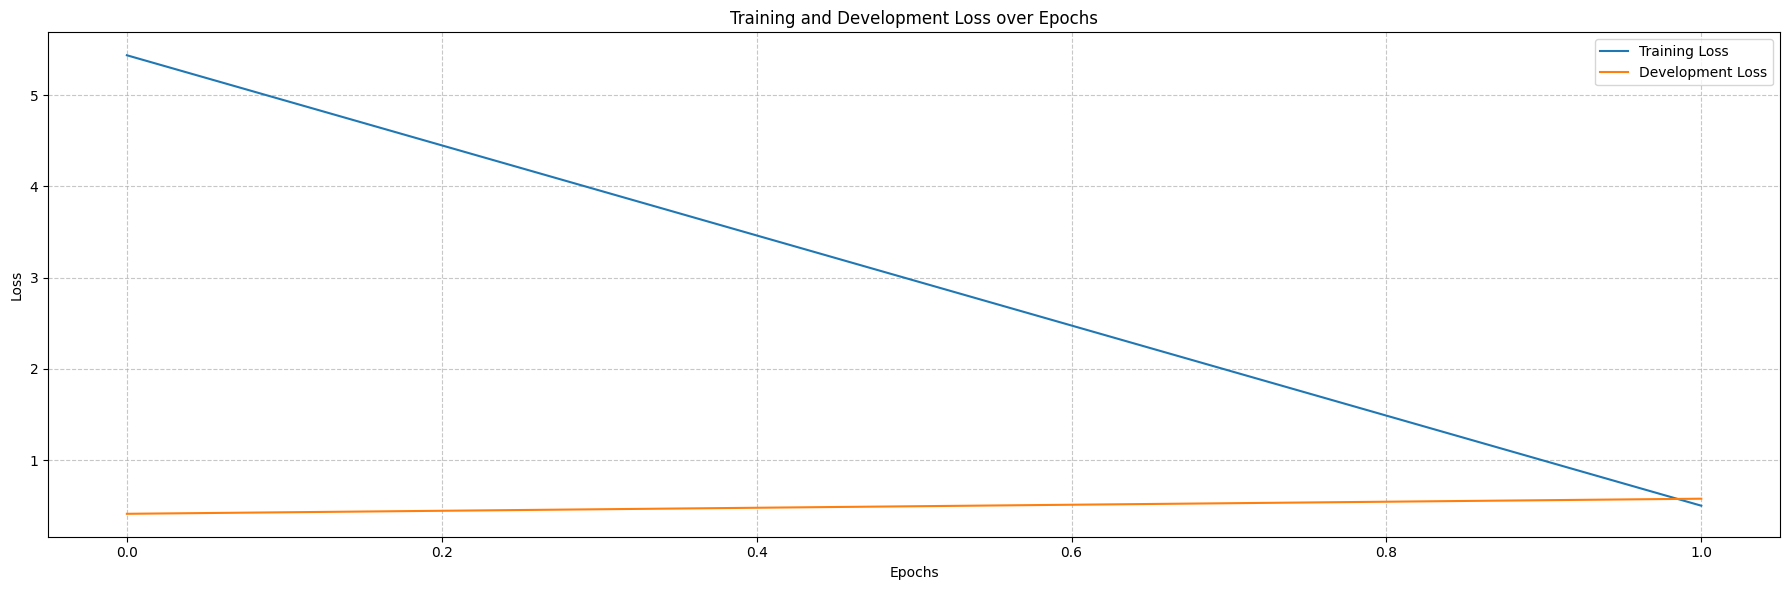

In [56]:
plt.figure(figsize=(18, 6))
plt.plot(total_loss_train_plot, label='Training Loss')
plt.plot(total_loss_test_plot, label='Development Loss')
plt.title('Training and Development Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

model.eval()
predictions = []
true_labels = []

with torch.no_grad():  # No gradient calculation during inference
    for index in range(len(val_dataset)):
        image, label = val_dataset[index]

        image = image.unsqueeze(0).to(device)  # Add batch dimension
        label = label.to(device)

        # Forward pass without labels (just get class logits)
        logits = model(image, label)

        # Predicted class
        pred_class = torch.argmax(logits, dim=1).item()

        predictions.append(pred_class)
        true_labels.append(label.item())

# Convert to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Metrics
print("Accuracy:", accuracy_score(true_labels, predictions))
print("Precision:", precision_score(true_labels, predictions, average='weighted'))
print("Recall:", recall_score(true_labels, predictions, average='weighted'))
print("F1 Score:", f1_score(true_labels, predictions, average='weighted'))
print("\nClassification Report:\n", classification_report(true_labels, predictions))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       227
           3       1.00      1.00      1.00       223
           4       1.00      1.00      1.00       292
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       110
           7       1.00      1.00      1.00       183
           8       1.00      1.00      1.00       245
           9       1.00      1.00      1.00       252
          10       1.00      1.00      1.00       251
          11       1.00      1.00      1.00       322
          12       1.00      1.00      1.00       152
          13       1.00      1.00      1.00       229
          14       1.00      1.00      1.00       140
          15       1.00      1.00      1.00       178
 

In [64]:
print(predictions)

[26 29 37 ...  7 49 26]


In [61]:
print(true_labels)

[26 29 37 ...  7 49 26]


In [67]:
torch.save(model.state_dict(), 'arcface.pt')

In [96]:
def face_age_prediction(model, image):
    import numpy as np
    import torch

    # If the image is a NumPy array, convert it to a torch tensor
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image)

    # Remove all singleton dimensions (dimensions with size 1)
    image = image.squeeze()

    # Ensure the tensor data type is float32
    if image.dtype != torch.float32:
        image = image.float()

    # Normalize the image if its values are in the [0, 255] range
    if image.max() > 1.0:
        image = image / 255.0

    # Change dimensions from (H, W, C) to (C, H, W)
    if image.ndim == 3 and image.shape[2] == 3:
        image = image.permute(2, 0, 1)

    # Add a batch dimension to get shape (1, C, H, W)
    if image.ndim == 3:
        image = image.unsqueeze(0)

    # Move the image to the same device as the model
    device = next(model.parameters()).device
    image = image.to(device)

    # Forward pass through the model
    model.eval()
    with torch.no_grad():
        return model(image).squeeze().cpu()

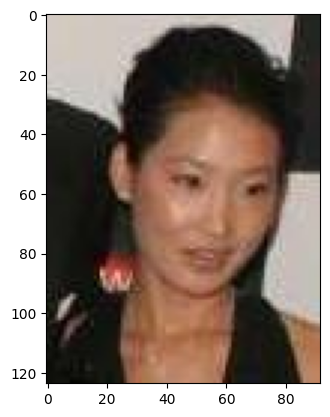

In [73]:
image = cv2.imread(path_sample)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_tensor = torch.tensor(image_rgb).to(device)
plt.imshow(image_rgb)
plt.show()

In [90]:
train_df.head(2)

,image_path,label
0,/content/vggface2/train/n000135/0015_01.jpg,0
1,/content/vggface2/train/n000135/0072_01.jpg,0


In [97]:
image1 = cv2.imread("/content/vggface2/train/n000135/0015_01.jpg")
image2 = cv2.imread("/content/vggface2/train/n000135/0072_01.jpg")
img_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img_rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

In [100]:
img1 = face_age_prediction(model, img_rgb)
img2 = face_age_prediction(model, img_rgb2)
img1 = img1.view(img1.size(0), -1)
img2 = img2.view(img2.size(0), -1)

In [109]:
cos_sim = F.cosine_similarity(img1, img2)

In [112]:
print(cos_sim.shape)  # torch.Size([128])

# Get average similarity
avg_sim = cos_sim.mean().item()
print("Average similarity:", avg_sim)

# Get similarity of first element
print("First similarity:", cos_sim[0].item())

torch.Size([128])
Average similarity: 1.0
First similarity: 1.0
